In [1]:
#gerekli kutuphaneleri kur
!pip install seqeval tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 887.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=58b442a57317f38942136ca58ba72a39dcb50876ca86cc8ab041f0827b5d3622
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [2]:
#vrisetini ykll
from google.colab import files

uploaded = files.upload()
filename = list(uploaded.keys())[0]
print(f"Yüklenen dosya: {filename}")


Saving veriseti.conll to veriseti.conll
Yüklenen dosya: veriseti.conll


In [3]:
#veriyi oku
def load_conll_data(filepath):
    sentences = []
    sentence = []
    with open(filepath, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("-DOCSTART-"):
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                parts = line.split()
                if len(parts) >= 2:
                    token = parts[0]
                    label = parts[-1]
                    sentence.append((token, label))
        if sentence:
            sentences.append(sentence)
    return sentences

data = load_conll_data(filename)
print(f"Toplam cümle sayısı: {len(data)}")
print("Örnek cümle:", data[0])


Toplam cümle sayısı: 38
Örnek cümle: [('Microsoft', 'B-ORG'), ('Türkiye', 'B-COUNTRY'), ("'den", 'O'), ('35', 'B-AGE'), ('yaşındaki', 'I-AGE'), ('yazılım', 'B-PROFESSION'), ('mühendisi', 'I-PROFESSION'), ('Ahmet', 'B-PERSON'), ('Bey', 'I-PERSON'), ('İstanbul', 'B-CITY'), ("'a", 'O'), ('taşındı', 'O'), ('.', 'O')]


In [4]:
#veriyi hazirla (tokeniz, label encode ve padding)
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

sentences = [[token for token, label in sent] for sent in data]
labels = [[label for token, label in sent] for sent in data]

word_tokenizer = Tokenizer(lower=True, oov_token='OOV')
word_tokenizer.fit_on_texts(sentences)
X = word_tokenizer.texts_to_sequences(sentences)

label_encoder = LabelEncoder()
flat_labels = [lab for sent in labels for lab in sent]
label_encoder.fit(flat_labels)
y = [label_encoder.transform(sent) for sent in labels]

max_len = max(len(s) for s in X)

X_padded = pad_sequences(X, maxlen=max_len, padding='post')
y_padded = pad_sequences(y, maxlen=max_len, padding='post', value=label_encoder.transform(['O'])[0])

print(f"Kelime sayısı: {len(word_tokenizer.word_index)}")
print(f"Etiket sayısı: {len(label_encoder.classes_)}")
print(f"Maksimum cümle uzunluğu: {max_len}")


Kelime sayısı: 344
Etiket sayısı: 25
Maksimum cümle uzunluğu: 29


In [5]:
#etikeetleri one hot encode et
from tensorflow.keras.utils import to_categorical

num_labels = len(label_encoder.classes_)
y_cat = [to_categorical(i, num_classes=num_labels) for i in y_padded]
y_cat = np.array(y_cat)


In [6]:
#egitim ve test verisi ayir
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_padded, y_cat, test_size=0.2, random_state=42)


In [7]:
#bilstm modeli kur
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, TimeDistributed, Dense, Dropout

vocab_size = len(word_tokenizer.word_index) + 1
embedding_dim = 128

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(num_labels, activation='softmax')))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)


In [9]:
#modeli egit
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1)))
model.add(Dense(num_labels, activation='softmax'))



In [10]:
#compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=5,
    verbose=1
)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0161 - loss: 3.2178 - val_accuracy: 0.6422 - val_loss: 3.2042
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7184 - loss: 3.1998 - val_accuracy: 0.7672 - val_loss: 3.1891
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7609 - loss: 3.1804 - val_accuracy: 0.3621 - val_loss: 3.1723
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.3414 - loss: 3.1585 - val_accuracy: 0.3621 - val_loss: 3.1530
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3414 - loss: 3.1330 - val_accuracy: 0.3621 - val_loss: 3.1305


In [12]:
#tahmin ve etiket donusumu
import numpy as np

# Tahminleri al
y_pred_prob = model.predict(X_val)

# En yuksek olasiliga sahip etiket indeksini sec
y_pred = np.argmax(y_pred_prob, axis=-1)
y_true = np.argmax(y_val, axis=-1)

# idx2label sözlüğünü hazırla
idx2label = {i: label for i, label in enumerate(label_encoder.classes_)}

# İndeksleri etiket isimlerine çevir
def idxs_to_labels(idxs, lengths):
    results = []
    for seq, length in zip(idxs, lengths):
        results.append([idx2label[idx] for idx in seq[:length]])
    return results

# Cümle uzunlukları (padding öncesi)
lengths = [len(sent) for sent in y_val]

y_true_labels = idxs_to_labels(y_true, lengths)
y_pred_labels = idxs_to_labels(y_pred, lengths)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


In [13]:
#classification matrix
from seqeval.metrics import classification_report, f1_score

print("--- CLASSIFICATION REPORT ---")
print(classification_report(y_true_labels, y_pred_labels))
print("F1-score:", f1_score(y_true_labels, y_pred_labels))


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

         AGE       0.00      0.00      0.00         4
        CITY       0.00      0.00      0.00         6
     COUNTRY       0.00      0.00      0.00         4
        DATE       0.00      0.00      0.00         4
         ORG       0.00      0.00      0.00         4
      PERSON       0.00      0.00      0.00         3
  PROFESSION       0.00      0.00      0.00         9
       STATE       0.00      0.00      0.00         1
      STREET       0.00      0.00      0.00         1
         URL       0.00      0.00      0.00         1
         ZIP       0.00      0.00      0.00         1

   micro avg       0.00      0.00      0.00        38
   macro avg       0.00      0.00      0.00        38
weighted avg       0.00      0.00      0.00        38

F1-score: 0.0


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


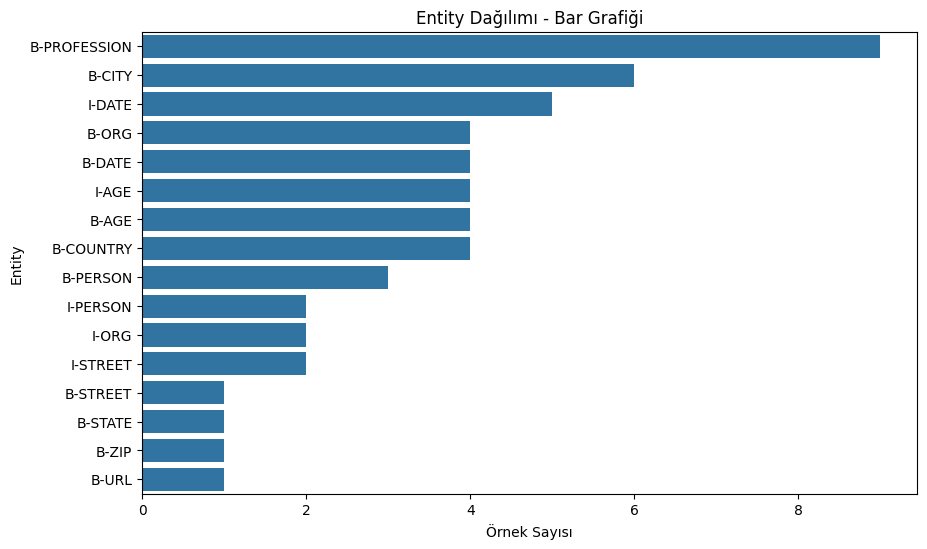

In [15]:
#etiket dağılımı (bar chart)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd

def plot_label_distribution_bar(y_true):
    all_labels = [label for sentence in y_true for label in sentence if label != 'O']
    label_counts = Counter(all_labels)
    df = pd.DataFrame(label_counts.items(), columns=['Entity', 'Count']).sort_values(by='Count', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Count', y='Entity', data=df)
    plt.title('Entity Dağılımı - Bar Grafiği')
    plt.xlabel('Örnek Sayısı')
    plt.ylabel('Entity')
    plt.show()

plot_label_distribution_bar(y_true_labels)



In [16]:
#donut chart
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np

def plot_label_distribution_pie(y_true, threshold=2):
    # 'O' olmayan etiketleri say
    all_labels = [label for sentence in y_true for label in sentence if label != 'O']
    label_counts = Counter(all_labels)

    df = pd.DataFrame(label_counts.items(), columns=['Entity', 'Count']).sort_values(by='Count', ascending=False)
    total = df['Count'].sum()
    df['Percent'] = 100 * df['Count'] / total

    # %2 altındakileri Diğer olarak grupla
    small = df[df['Percent'] < threshold]
    large = df[df['Percent'] >= threshold]

    if not small.empty:
        others_sum = small['Count'].sum()
        others_percent = 100 * others_sum / total
        others_df = pd.DataFrame({'Entity': ['Diğer'], 'Count': [others_sum], 'Percent': [others_percent]})
        large = pd.concat([large, others_df], ignore_index=True)

    labels = [f"{row['Entity']} ({row['Percent']:.1f}%)" for _, row in large.iterrows()]
    sizes = large['Count']

    fig, ax = plt.subplots(figsize=(8,8))
    wedges, texts, autotexts = ax.pie(sizes, labels=None, autopct='%1.1f%%', startangle=140, pctdistance=0.85)

    # İç daire ile donut efekti
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig.gca().add_artist(centre_circle)

    # Yazıları dışa taşı ve okunaklı yap
    kw = dict(arrowprops=dict(arrowstyle="-"), bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.72), zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        ha = {-1: "right", 1: "left"}[int(np.sign(x))]
        ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y), horizontalalignment=ha, **kw)

    plt.title("Entity Dağılımı - Gruplanmış Donut Chart", fontsize=16)
    plt.show()


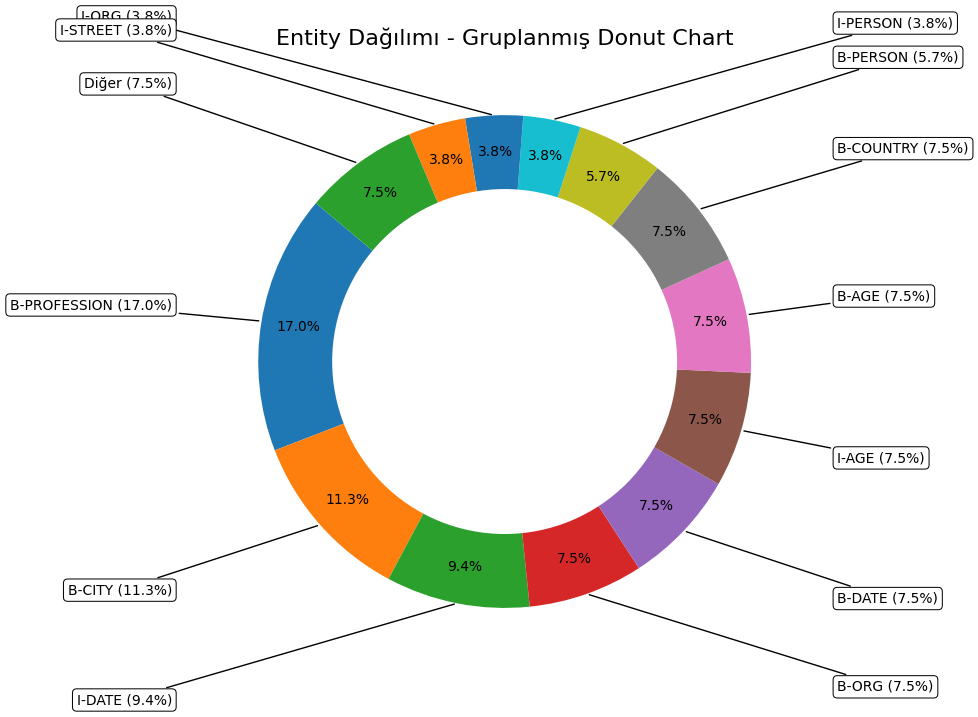

In [17]:
#donut chart metodunu cagir
plot_label_distribution_pie(y_true_labels, threshold=2)


In [18]:
#confusion martix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels):
    # Düzleştirilmiş gerçek ve tahmin etiketleri
    y_true_flat = [item for sublist in y_true for item in sublist]
    y_pred_flat = [item for sublist in y_pred for item in sublist]

    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.xlabel('Tahmin Edilen Etiketler')
    plt.ylabel('Gerçek Etiketler')
    plt.title('Confusion Matrix')
    plt.show()


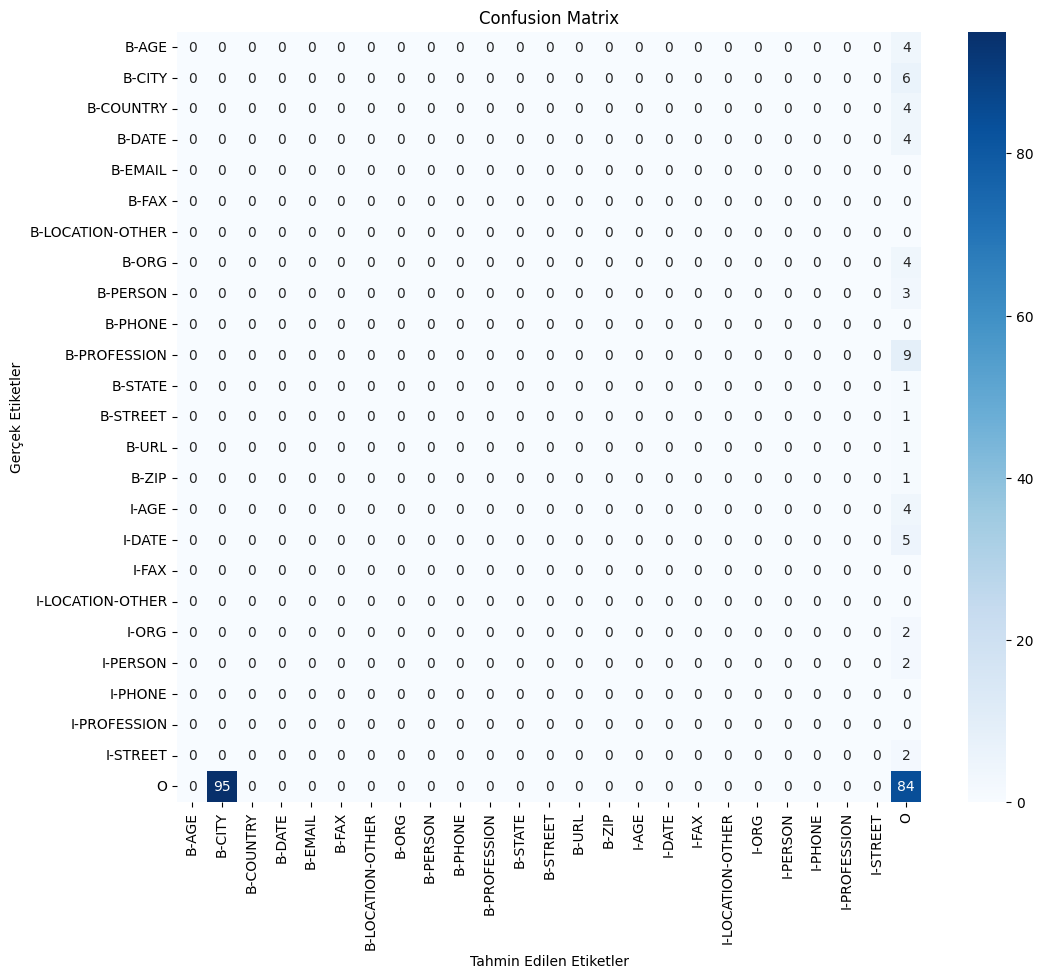

In [19]:
#confusion matrik metot cagir
labels = list(label_encoder.classes_)  # Etiket listesini hazırla
plot_confusion_matrix(y_true_labels, y_pred_labels, labels)


In [20]:
#Annoted HTML
from IPython.core.display import display, HTML

def generate_annotated_html(tokens, labels):
    entity_colors = {
        "PERSON": "#F48FB1",
        "CITY": "#A5D6A7",
        "PROFESSION": "#FFB74D",
        "EMAIL": "#F8BBD0",
        "STREET": "#B0BEC5",
        "PHONE": "#90CAF9",
        "AGE": "#4DD0E1",
        "ORG": "#80CBC4",
        "URL": "#CE93D8",
        "COUNTRY": "#AED581",
        "DATE": "#81D4FA",
        "STATE": "#E6EE9C",
        "ZIP": "#FFD54F",
        "O": "#FFFFFF"  # Etiketsiz kelimeler için beyaz
    }

    html = "<div style='font-family:monospace; line-height:2;'>"

    for token, label in zip(tokens, labels):
        main_label = label.split("-")[-1] if label != "O" else "O"
        color = entity_colors.get(main_label, "#E0E0E0")
        if main_label != "O":
            html += f"<span style='background-color:{color}; padding:4px; margin:2px; border-radius:4px;'>{token} <small><strong>{main_label}</strong></small></span> "
        else:
            html += f"{token} "

    html += "</div>"

    display(HTML(html))


In [21]:
#Annoted HTML ornek cumle
sample_index = 5
tokens = [word_tokenizer.index_word.get(idx, '') for idx in X_padded[sample_index] if idx != 0]
labels = y_true_labels[sample_index]  # ya da y_pred_labels[sample_index]

generate_annotated_html(tokens, labels)
